In [11]:
import sys; sys.path.insert(0, '..')

In [12]:
import pandas as pd
import re
from tqdm import notebook
from re import compile
from utils.regex_fx import remove_single_char, remove_numbers, remove_urls, remove_emojis, remove_extra_spaces, remove_rt, remove_mention, remove_nonalpha, remove_non_ascii
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [13]:
pr = pd.read_csv('../processed-data/tweet_times/politifact_real_tweet_times.csv')

/Users/vangelistrikoupis/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
pr

,Unnamed: 0,id,text,author_id,created_at,news_id,withheld
0,0,9.671323e+17,"""According to a new survey by the National Fed...",868603454,2018-02-23T20:21:13.000Z,politifact14984,NaN
1,1,9.671644e+17,Small business owners: join the National Feder...,2253869227,2018-02-23T22:28:49.000Z,politifact14984,NaN
2,2,9.672156e+17,"@TrumpGuyTV @thebradfordfile Right, because th...",168771859,2018-02-24T01:52:28.000Z,politifact14984,NaN
3,3,9.673861e+17,Nearly a third of Main Street businesses say i...,4870450553,2018-02-24T13:10:05.000Z,politifact14984,NaN
4,4,9.682384e+17,HR704 [NEW] Commemorating the 75th anniversary...,104713697,2018-02-26T21:36:27.000Z,politifact14984,NaN
...,...,...,...,...,...,...,...
271792,271772,1.013255e+18,@bigdaddycaddy2 Oh definitely not right now......,343199203,2018-07-01T02:57:06.000Z,politifact329,NaN
271793,271773,1.013889e+18,@JKapitzky @TRVLRSseries It's my favorite show...,30988436,2018-07-02T20:57:18.000Z,politifact329,NaN
271794,271774,1.014195e+18,I can't remember an administration so dead-set...,14870085,2018-07-03T17:13:23.000Z,politifact329,NaN
271795,271775,1.018158e+18,The Past versus The Future https://t.co/fBON9v...,1004436371988197377,2018-07-14T15:38:32.000Z,politifact329,NaN


In [28]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(text)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    return res

In [29]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [33]:
cleaned_pr_text = []
for item in pr.text:
    try:
        cleaned_pr_text.append(cleanup(item))
    except TypeError as err:
        cleaned_pr_text.append('')
pr.text = cleaned_pr_text

In [34]:
pr = pr.drop_duplicates(subset=['text'], keep='first')
pr = pr.sort_values('text')

In [35]:
pr.reset_index(drop=True, inplace=True)
for index, item in pr.iterrows():
    if index < len(pr)-1:
        if similar(pr.loc[index,'text'], pr.loc[index+1,'text']) > 0.90:
            pr.drop(index, inplace = True)

In [36]:
pr = pr[pr.text.notnull()]
pr = pr[pr.text != ""]
pr = pr[pr.text.str.len() > 15]

In [37]:
pr = pr.drop(columns=['Unnamed: 0', 'withheld'])

In [38]:
text_list = pr.text.unique()
processed_texts = [text for text in notebook.tqdm(nlp.pipe(text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(text_list))]

  0%|          | 0/196974 [00:00<?, ?it/s]

In [39]:
tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]

  0%|          | 0/196974 [00:00<?, ?it/s]

In [40]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [ ]:
def process_tokenized(tokenized_texts):
    # tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flattened = flatten(tokenized_texts)
    counts = Counter(flattened)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flattened, tokenized_texts

In [43]:
tokenized_obj = process_tokenized(tokenized_texts)
counts_real, common_real, flattened_real, tokenized_texts_rea = tokenized_obj

In [54]:
common_real[:20]

[('trump', 25485),
 ('nt', 24389),
 ('state', 19251),
 ('interview', 19106),
 ('president', 16686),
 ('news', 14836),
 ('amp', 13594),
 ('statement', 12464),
 ('say', 12323),
 ('s', 12212),
 ('speech', 11923),
 ('like', 11644),
 ('meetthepress', 11199),
 ('union', 10917),
 ('video', 10432),
 ('cnn', 10045),
 ('realdonaldtrump', 9806),
 ('people', 9539),
 ('time', 9501),
 ('fox', 9029)]

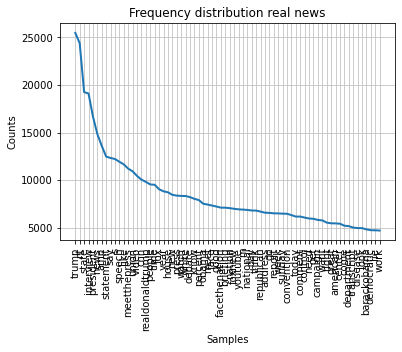

<AxesSubplot:title={'center':'Frequency distribution real news'}, xlabel='Samples', ylabel='Counts'>

In [56]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_real)
fdist_filtered.plot(70,title='Frequency distribution real news')

In [57]:
from gensim.models import LdaMulticore

def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in notebook.tqdm(range(start, limit, step)):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.01, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [58]:
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=1, step=1, limit= 40, topn=5)

  0%|          | 0/39 [00:00<?, ?it/s]

In [59]:
coherence_values

[0.14163010651750363,
 0.31026468440595684,
 0.3668810446252699,
 0.29403257846739167,
 0.45519090135578033,
 0.4536312480640265,
 0.47874595131344383,
 0.5017217093333531,
 0.48366696389317176,
 0.5046106009077416,
 0.5394972612262152,
 0.5747786469769977,
 0.5018123302319896,
 0.5747888994408001,
 0.5725408871553751,
 0.5520041269313791,
 0.552512153374525,
 0.5580815416125225,
 0.5787816330877079,
 0.5628464347801229,
 0.5638986178600872,
 0.5787603428784622,
 0.5813644929529665,
 0.5812943091085214,
 0.5790460436176741,
 0.6076246626783447,
 0.627098543691379,
 0.6203777470147693,
 0.5760892775260064,
 0.5953074315660417,
 0.6144468987465774,
 0.6494532700465555,
 0.5872708416379516,
 0.6265686543098155,
 0.6356537142337854,
 0.5946294619255754,
 0.6214110829534935,
 0.6189103936337625,
 0.6126978190874132]

In [60]:
from gensim.corpora import Dictionary

In [61]:
MIN_DF = 5 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary = Dictionary(tokenized_texts_real) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in notebook.tqdm(tokenized_texts_real)]

  0%|          | 0/196974 [00:00<?, ?it/s]

In [62]:
N_TOPICS = 6
N_ITERATIONS = 1000

lda = LdaMulticore(
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)
                
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: state union department obama video meet youtube education address like
Topic 1: nt interview meetthepress trump realdonaldtrump s state foxnew like year
Topic 2: trump debate nt speech presidential transcript amp people president time
Topic 3: house white briefing press news control new interview disease center
Topic 4: face nation speech amp cnn convention trump care act good
Topic 5: trump president statement news nt fox say interview video congress


In [63]:
pr.to_csv('real.csv')